# SMART BIRDFEEDER: Birb.io

## A machine learning project

#### Jack Edney

### Day 2 Building TFData Pipeline

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
tf.__version__

'2.4.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Importing the data:

In [4]:
PATH = "USBirbs/CUB_200_2011/CUB_200_2011"

In [5]:
import pathlib

In [6]:
image_path = pathlib.Path(os.path.join(PATH, 'images'))

In [7]:
list_ds = tf.data.Dataset.list_files(str(image_path/'*/*'), shuffle=False)
# Importing the images into a tf.dataset

In [8]:
for f in list_ds.take(5):
    print(f.numpy())

b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0002_55.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0005_796090.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0006_796065.jpg'


In [9]:
n_images = len(list_ds)
print(n_images)
# Let's see how many images we have

11788


In [10]:
list_ds = list_ds.shuffle(n_images, reshuffle_each_iteration=False)
# Shuffle the images

In [11]:
for f in list_ds.take(5):
    print(f.numpy())
# The data is now shuffled

b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\053.Western_Grebe\\Western_Grebe_0092_36121.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\085.Horned_Lark\\Horned_Lark_0013_74374.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\065.Slaty_backed_Gull\\Slaty_Backed_Gull_0058_796024.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\170.Mourning_Warbler\\Mourning_Warbler_0073_166524.jpg'
b'USBirbs\\CUB_200_2011\\CUB_200_2011\\images\\024.Red_faced_Cormorant\\Red_Faced_Cormorant_0050_796276.jpg'


In [12]:
class_names = np.array(sorted([item.name for item in image_path.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)
# Getting the class names

['001.Black_footed_Albatross' '002.Laysan_Albatross' '003.Sooty_Albatross'
 '004.Groove_billed_Ani' '005.Crested_Auklet' '006.Least_Auklet'
 '007.Parakeet_Auklet' '008.Rhinoceros_Auklet' '009.Brewer_Blackbird'
 '010.Red_winged_Blackbird' '011.Rusty_Blackbird'
 '012.Yellow_headed_Blackbird' '013.Bobolink' '014.Indigo_Bunting'
 '015.Lazuli_Bunting' '016.Painted_Bunting' '017.Cardinal'
 '018.Spotted_Catbird' '019.Gray_Catbird' '020.Yellow_breasted_Chat'
 '021.Eastern_Towhee' '022.Chuck_will_Widow' '023.Brandt_Cormorant'
 '024.Red_faced_Cormorant' '025.Pelagic_Cormorant' '026.Bronzed_Cowbird'
 '027.Shiny_Cowbird' '028.Brown_Creeper' '029.American_Crow'
 '030.Fish_Crow' '031.Black_billed_Cuckoo' '032.Mangrove_Cuckoo'
 '033.Yellow_billed_Cuckoo' '034.Gray_crowned_Rosy_Finch'
 '035.Purple_Finch' '036.Northern_Flicker' '037.Acadian_Flycatcher'
 '038.Great_Crested_Flycatcher' '039.Least_Flycatcher'
 '040.Olive_sided_Flycatcher' '041.Scissor_tailed_Flycatcher'
 '042.Vermilion_Flycatcher' '043.Ye

In [13]:
val_size = int(n_images * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
# Splitting the dataset into train and validate sets

In [14]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

9431
2357


The following functions are from the Tensorflow website

In [15]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [16]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [17]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [18]:
img_height, img_width = 224, 224
batch_size = 90

In [19]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
# Caches, shuffles and prefetches the batches to improve speed

In [21]:
image_batch, label_batch = next(iter(train_ds))

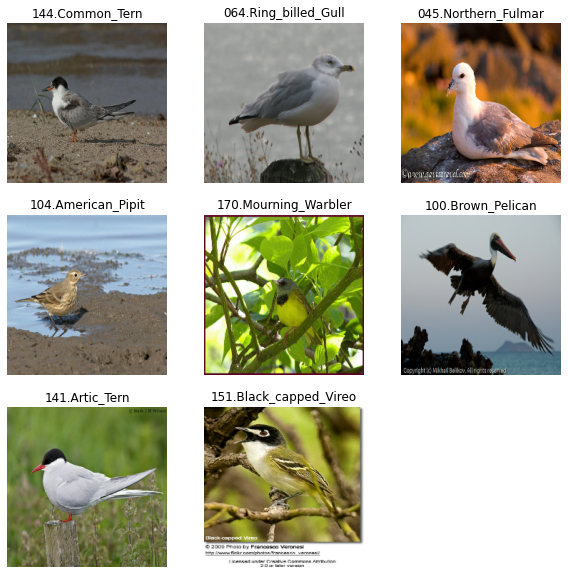

In [22]:
plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")
# Checking the image and labels are correctly paired

### Importing the model:

In [23]:
from tensorflow.keras.applications import MobileNetV3Large
# We're trying a larger version of MobileNetV3 to improve our validation accuracy

In [24]:
def initialise_model(model):
    dropout_1 = keras.layers.Dropout(rate=0.2)(model.output)
    output = keras.layers.Dense(200, activation='softmax')(dropout_1)
    return keras.models.Model(inputs=model.input, outputs=output)

In [25]:
full_model = initialise_model(MobileNetV3Large(input_shape=(img_height, img_width, 3), minimalistic=True, weights='imagenet', dropout_rate=0.2, include_top=False, pooling='max'))

In [26]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

### Training:

In [27]:
for layer in full_model.layers:
    layer.trainable=False
for layer in full_model.layers[:60]:
    layer.trainable=False
for layer in full_model.layers[60:]:
    layer.trainable=True

In [28]:
full_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
full_model.fit(train_ds, 
               validation_data=val_ds,
              epochs=5)
# Using a tf.data dataframe instead of a Keras imagedatagenerator has vastly sped up our training despite using a larger model

Epoch 1/5
105/105 [==============================] - 47s 307ms/step - loss: 9.5866 - accuracy: 0.0100 - val_loss: 10.4879 - val_accuracy: 0.0199
Epoch 2/5
105/105 [==============================] - 26s 250ms/step - loss: 4.2677 - accuracy: 0.0839 - val_loss: 6.7866 - val_accuracy: 0.0645
Epoch 3/5
105/105 [==============================] - 27s 255ms/step - loss: 2.9105 - accuracy: 0.2621 - val_loss: 6.5218 - val_accuracy: 0.1137
Epoch 4/5
105/105 [==============================] - 27s 253ms/step - loss: 1.9973 - accuracy: 0.4517 - val_loss: 6.7575 - val_accuracy: 0.1260
Epoch 5/5
105/105 [==============================] - 27s 255ms/step - loss: 1.4616 - accuracy: 0.5778 - val_loss: 4.5739 - val_accuracy: 0.2571


In [30]:
for layer in full_model.layers:
    layer.trainable=False
for layer in full_model.layers[:40]:
    layer.trainable=False
for layer in full_model.layers[40:]:
    layer.trainable=True

In [31]:
for layer in full_model.layers:
    layer.trainable=True

In [32]:
full_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
full_model.fit(train_ds,
               validation_data=val_ds,
              epochs=30)

Epoch 1/30
 29/105 [=======>......................] - ETA: 39s - loss: 1.1461 - accuracy: 0.6566

In [ ]:
for layer in full_model.layers:
    layer.trainable=False
for layer in full_model.layers[:20]:
    layer.trainable=False
for layer in full_model.layers[20:]:
    layer.trainable=True

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
full_model.fit(train_ds,
               validation_data=val_ds,
              epochs=7)

In [ ]:
for layer in full_model.layers:
    layer.trainable=True

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
full_model.fit(train_ds,
               validation_data=val_ds,
              epochs=3)

We've ended up with a validation accuracy of 68 percent. This is without data augmentation